In [1]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 读取数据
citeseer_content = pd.read_csv('./data/citeseer.content', sep='\t', header=None)
citeseer_cites = pd.read_csv('./data/citeseer.cites', sep='\t', header=None)

# 准备节点特征和标签
labels = pd.get_dummies(citeseer_content.iloc[:, -1]).values.argmax(axis=1)
features = citeseer_content.iloc[:, 1:-1].values
node_features = torch.tensor(features, dtype=torch.float)

# 准备边索引
paper_ids = citeseer_content.iloc[:, 0]
id_map = {j: i for i, j in enumerate(paper_ids)}

# 安全地将节点ID转换为索引，跳过不存在的ID
edges = []
for _, row in citeseer_cites.iterrows():
    src = id_map.get(row[0])
    dst = id_map.get(row[1])
    if src is not None and dst is not None:
        edges.append([src, dst])

edges = np.array(edges).T
edge_index = torch.tensor(edges, dtype=torch.long)

# 准备图数据
data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(labels, dtype=torch.long))

# 划分数据集
indices = np.arange(data.num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=0, stratify=labels)

# 创建训练集、验证集索引
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=0, stratify=labels[train_idx])

data.train_idx = torch.tensor(train_idx, dtype=torch.long)
data.val_idx = torch.tensor(val_idx, dtype=torch.long)
data.test_idx = torch.tensor(test_idx, dtype=torch.long)

# 输出一些统计信息
print("Total nodes:", data.num_nodes)
print("Total edges:", len(edges[0]))  # 更新边的总数
print("Train nodes:", len(train_idx))
print("Validation nodes:", len(val_idx))
print("Test nodes:", len(test_idx))
print(features.shape)


C:\Users\86139\AppData\Local\Temp\ipykernel_24756\1042751718.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  citeseer_content = pd.read_csv('./data/citeseer.content', sep='\t', header=None)


Total nodes: 3312
Total edges: 3298
Train nodes: 2682
Validation nodes: 298
Test nodes: 332
(3312, 3703)


In [2]:
from types import SimpleNamespace
import torch

config = SimpleNamespace(
    seed = 0,
    learning_rate = 0.001,
    weight_decay = 1e-4,  # 调整权重衰减，适合小型图数据集
    input_dim = 3703,  
    output_dim = 6,  
    hidden_size = 128,
    num_epochs = 200,
    checkpoints_dir = './models/citeseer_gnn',
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

print("Using device:", config.device)


Using device: cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    device = y_pred.device
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()
    y_test = y_test.to(device)
    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc

class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dim_feature, heads=8):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h * heads)
        self.gat2_class = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.6)
        self.gat2_feature = GATv2Conv(dim_h * heads, dim_feature, heads=heads, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out_class = self.gat2_class(h, edge_index)
        out_feature = self.gat2_feature(h, edge_index)
        return out_class, out_feature

class FullyConnectedDecoder(torch.nn.Module):
    def __init__(self, dim_feature, dim_out=3703):  # 修改输出维度以匹配原始特征维度
        super(FullyConnectedDecoder, self).__init__()
        self.fc1 = torch.nn.Linear(dim_feature, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        return x

class GATAutoencoder(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dim_feature, heads=8):
        super(GATAutoencoder, self).__init__()
        self.encoder = GAT(dim_in, dim_h, dim_out, dim_feature, heads)
        self.decoder = FullyConnectedDecoder(dim_feature, dim_in)  # 输出维度与输入特征维度一致

    def forward(self, x, edge_index):
        out_class, out_feature = self.encoder(x, edge_index)
        reconstructed = self.decoder(out_feature)
        return out_class, reconstructed, out_feature


In [4]:
import torch
import os
import copy

# 更新训练函数
def train_evaluate(model, data, criterion_class, criterion_recon, optimizer, config):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(config.num_epochs + 1):
        model.train()
        optimizer.zero_grad()

        out_class, reconstructed, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        loss_class = criterion_class(out_class[data.train_idx], data.y[data.train_idx].to(config.device))
        loss_recon = criterion_recon(reconstructed[data.train_idx], data.x[data.train_idx].to(config.device))

        loss = loss_class + loss_recon
        loss.backward(retain_graph=True)
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
            val_loss = criterion_class(out_class[data.val_idx], data.y[data.val_idx].to(config.device))

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val Loss: {val_loss:.4f}')
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model with best validation loss")
                torch.save(model.state_dict(), os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{epoch}.pth'))

    return model


In [5]:
import torch
from torch.optim import Adam
import torch.nn as nn

# 设定随机种子以确保实验的可重复性
torch.manual_seed(config.seed)

# 设置模型的隐藏层大小、特征头输出维度、注意力头的数量及训练周期数
config.hidden_size = 32  # 减小隐藏层大小
config.dim_feature = 3703  # 根据Cora数据集特征维度设置
config.heads = 8  # 设置注意力机制的头数
config.num_epochs = 50  # 设置训练周期数

# 创建自编码器模型实例
autoencoder_model = GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.dim_feature, config.heads).to(config.device)

# 创建优化器
optimizer = Adam(autoencoder_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)


criterion_class = nn.CrossEntropyLoss()

# 创建均方误差损失函数，用于重构任务
criterion_recon = nn.MSELoss()

# 训练模型，并在训练过程中进行评估
trained_model = train_evaluate(autoencoder_model, data, criterion_class, criterion_recon, optimizer, config)

# 在此输出是为了确认训练完成
print("Training completed")


Epoch   0 | Train Loss: 1.854 | Val Loss: 1.7632
Saving model with best validation loss
Epoch  10 | Train Loss: 0.783 | Val Loss: 1.5198
Saving model with best validation loss
Epoch  20 | Train Loss: 0.457 | Val Loss: 1.2097
Saving model with best validation loss
Epoch  30 | Train Loss: 0.306 | Val Loss: 0.9230
Saving model with best validation loss
Epoch  40 | Train Loss: 0.215 | Val Loss: 0.7612
Saving model with best validation loss
Epoch  50 | Train Loss: 0.175 | Val Loss: 0.7490
Saving model with best validation loss
Training completed


In [5]:
def test(model, data, config):
    model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_40.pth')))
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 不计算梯度
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))  # 接收所有返回值
        preds = torch.softmax(out_class, dim=1).max(1)[1]  # 获取预测的类别索引
    return preds

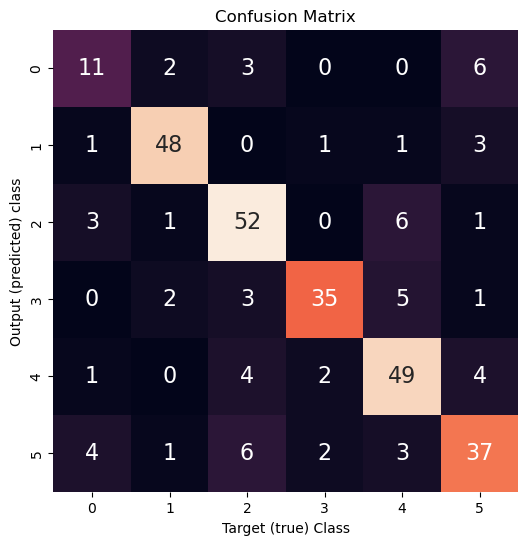

              precision    recall  f1-score   support

     Class 0     0.5500    0.5000    0.5238        22
     Class 1     0.8889    0.8889    0.8889        54
     Class 2     0.7647    0.8254    0.7939        63
     Class 3     0.8750    0.7609    0.8140        46
     Class 4     0.7656    0.8167    0.7903        60
     Class 5     0.7115    0.6981    0.7048        53

    accuracy                         0.7785       298
   macro avg     0.7593    0.7483    0.7526       298
weighted avg     0.7791    0.7785    0.7777       298



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# 设置模型的隐藏层大小、特征头输出维度、注意力头的数量及训练周期数
config.hidden_size = 32  # 减小隐藏层大小
config.dim_feature = 3703  # 根据Cora数据集特征维度设置
config.heads = 8  # 设置注意力机制的头数
config.num_epochs = 50  # 设置训练周期数
# 测试模型，并获取测试预测结果
trained_model=GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.dim_feature, config.heads).to(config.device)
y_test_preds = test(trained_model, data, config)

# 混淆矩阵
conf_mat = confusion_matrix(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu())
# 生成混淆矩阵。这个矩阵展示了模型在验证集上的预测结果与实际标签之间的关系。

plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class')
plt.ylabel('Output (predicted) class')
plt.title('Confusion Matrix')
plt.show()
# 混淆矩阵的每个单元格显示实际类别与预测类别的匹配程度。

# 获取类别名称
class_labels = [f'Class {i}' for i in range(data.y.unique().max() + 1)]

# 分类报告
print(classification_report(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu(), target_names=class_labels,digits=4))
# 这个报告提供了模型在各个类别上的精确度、召回率、F1分数等指标。

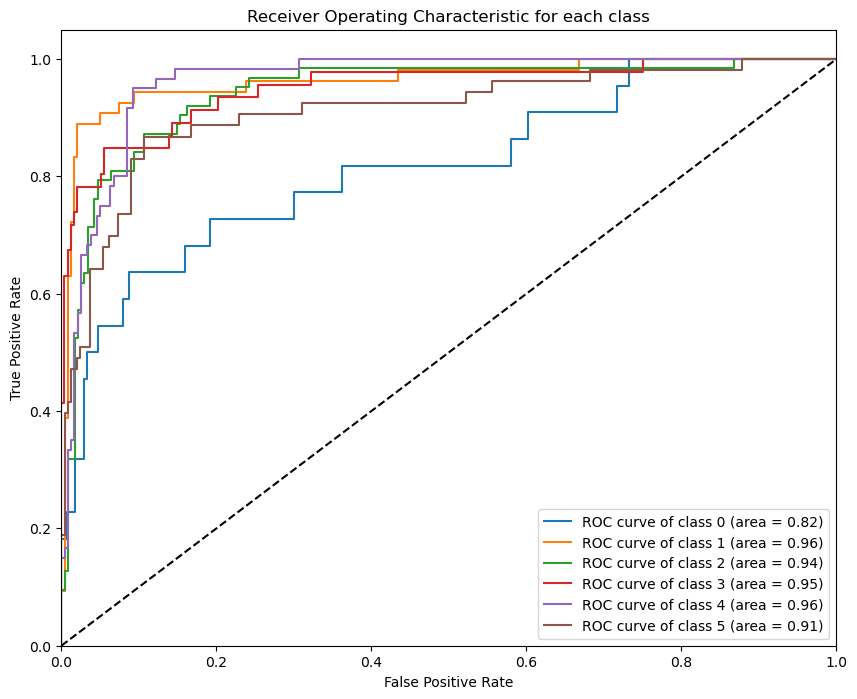

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_50.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        # 获取每个类别的概率分布
        preds_proba = F.softmax(out_class, dim=1)
    return preds_proba[data.val_idx]

# 测试模型并获取预测概率
y_test_proba = test(trained_model, data, config).cpu().numpy()
y_true = data.y[data.val_idx].detach().cpu().numpy()

# 二值化真实标签
num_classes = 6  # 标签从0到6，共有7个类别
y_true_binary = label_binarize(y_true, classes=range(num_classes))

# 计算每个类别的ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

In [11]:
# 标签判别器，处理分类结果
class LabelDiscriminator(torch.nn.Module):
    def __init__(self, num_classes):
        super(LabelDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_classes, 64),  # 输入维度为类别数
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 特征判别器，处理特征向量
class FeatureDiscriminator(torch.nn.Module):
    def __init__(self, feature_dim):
        super(FeatureDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.model(features)

# 示例初始化
label_discriminator = LabelDiscriminator(num_classes=6).to(config.device)
feature_discriminator = FeatureDiscriminator(feature_dim=3703).to(config.device)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

def train_evaluate(model, label_discriminator, feature_discriminator, data, criterion_class, criterion_recon, optimizer, optimizer_D, optimizer_FD, config):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    criterion_D = torch.nn.BCELoss()
    criterion_FD = torch.nn.BCELoss()

    for epoch in range(config.num_epochs + 1):
        model.train()
        label_discriminator.train()
        feature_discriminator.train()

        optimizer.zero_grad()
        optimizer_D.zero_grad()
        optimizer_FD.zero_grad()

        out_class, reconstructed, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        predicted_labels = F.softmax(out_class, dim=1).detach()  # Ensure we detach predicted labels

        loss_class = criterion_class(out_class[data.train_idx], data.y[data.train_idx].to(config.device))
        loss_recon = criterion_recon(reconstructed[data.train_idx], data.x[data.train_idx].to(config.device))

        real_labels = F.one_hot(data.y[data.train_idx].to(config.device), num_classes=6).float()  # Convert to one-hot
        real_loss = criterion_D(label_discriminator(real_labels), torch.ones(real_labels.size(0), 1, device=config.device))
        fake_loss = criterion_D(label_discriminator(predicted_labels[data.train_idx]), torch.zeros(predicted_labels[data.train_idx].size(0), 1, device=config.device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward(retain_graph=True)  # Ensure we keep the graph for the next backward pass

        real_feature_loss = criterion_FD(feature_discriminator(data.x[data.train_idx].detach().to(config.device)), torch.ones(data.train_idx.size(0), 1, device=config.device))
        fake_feature_loss = criterion_FD(feature_discriminator(out_feature[data.train_idx].detach()), torch.zeros(data.train_idx.size(0), 1, device=config.device))
        fd_loss = (real_feature_loss + fake_feature_loss) / 2
        fd_loss.backward(retain_graph=True)  # Ensure we keep the graph for the next backward pass

        g_loss = (0.3 * loss_class + 0.4 * d_loss + 0.3 * fd_loss)
        g_loss.backward()  # Final backward pass where we do not need to retain the graph
        optimizer.step()

        if epoch % 10 == 0 or epoch == config.num_epochs:
            val_loss = evaluate(model, label_discriminator, feature_discriminator, data, criterion_class, criterion_D, criterion_FD, config)
            print(f'Epoch {epoch:>3} | Train Loss: {g_loss.item():.3f} | D Loss: {d_loss.item():.3f} | FD Loss: {fd_loss.item():.3f} | Val Loss: {val_loss:.3f}')
            if val_loss < best_loss:
                print("Saving model with best validation loss")
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f'{config.checkpoints_dir}/best2_model_epoch_{epoch}.pth')

    model.load_state_dict(best_model_wts)
    return model


def evaluate(model, label_discriminator, feature_discriminator, data, criterion_class, criterion_D, criterion_FD, config):
    model.eval()
    label_discriminator.eval()
    feature_discriminator.eval()
    with torch.no_grad():
        out_class, _, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        val_loss = criterion_class(out_class[data.val_idx], data.y[data.val_idx].to(config.device)).item()
    return val_loss

def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_{config.num_epochs}.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        preds = torch.argmax(F.softmax(out_class, dim=1), dim=1)  # Using softmax to handle multi-class output
    return preds

In [13]:
torch.autograd.set_detect_anomaly(True)

In [12]:
# 设置随机种子以保证结果的可复现性
torch.manual_seed(config.seed)

# 更新隐藏层大小和特征头输出维度以适应Cora数据集
config.hidden_size = 32  # 减小隐藏层大小
config.dim_feature = 3703  # 减小特征头输出维度
config.heads = 8         # 设置注意力头的数量
config.num_epochs = 60  # 设置训练的轮次

# 创建模型实例

autoencoder_model = GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.dim_feature, config.heads).to(config.device)
autoencoder_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_40.pth')))
# 创建优化器和损失函数
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion_class = torch.nn.CrossEntropyLoss()  # 使用交叉熵损失函数，适用于多分类问题
criterion_recon = torch.nn.MSELoss()  # 均方误差损失函数，用于重构任务

# 定义标签和特征判别器及其优化器
label_discriminator = LabelDiscriminator(num_classes=6).to(config.device)
feature_discriminator = FeatureDiscriminator(feature_dim=config.dim_feature).to(config.device)

optimizer_label_D = Adam(label_discriminator.parameters(), lr=0.001)
optimizer_feature_D = Adam(feature_discriminator.parameters(), lr=0.001)

# 开始训练和评估模型
trained_model = train_evaluate(autoencoder_model, label_discriminator, feature_discriminator, data, criterion_class, criterion_recon, optimizer, optimizer_label_D, optimizer_feature_D, config)



Epoch   0 | Train Loss: 0.540 | D Loss: 0.697 | FD Loss: 0.694 | Val Loss: 0.753
Saving model with best validation loss
Epoch  10 | Train Loss: 0.534 | D Loss: 0.698 | FD Loss: 0.694 | Val Loss: 0.760
Epoch  20 | Train Loss: 0.521 | D Loss: 0.698 | FD Loss: 0.694 | Val Loss: 0.890
Epoch  30 | Train Loss: 0.516 | D Loss: 0.698 | FD Loss: 0.694 | Val Loss: 1.029
Epoch  40 | Train Loss: 0.511 | D Loss: 0.698 | FD Loss: 0.694 | Val Loss: 1.115
Epoch  50 | Train Loss: 0.506 | D Loss: 0.698 | FD Loss: 0.694 | Val Loss: 1.169
Epoch  60 | Train Loss: 0.505 | D Loss: 0.697 | FD Loss: 0.694 | Val Loss: 1.216


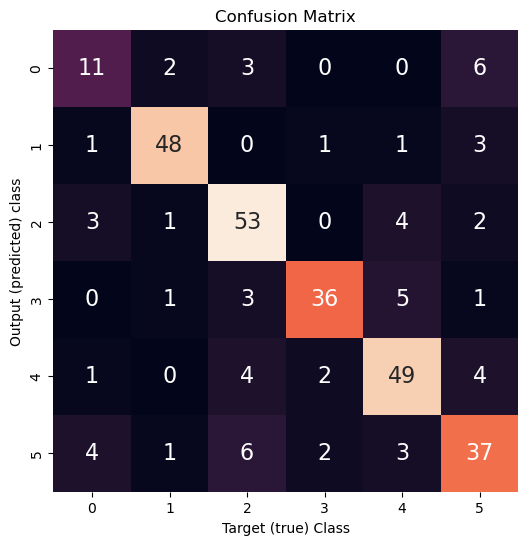

              precision    recall  f1-score   support

           0     0.5500    0.5000    0.5238        22
           1     0.9057    0.8889    0.8972        54
           2     0.7681    0.8413    0.8030        63
           3     0.8780    0.7826    0.8276        46
           4     0.7903    0.8167    0.8033        60
           5     0.6981    0.6981    0.6981        53

    accuracy                         0.7852       298
   macro avg     0.7650    0.7546    0.7588       298
weighted avg     0.7859    0.7852    0.7847       298



In [16]:
def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_0.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        preds = torch.argmax(torch.softmax(out_class, dim=1), dim=1)  # Get the predicted classes
    return preds

trained_model=GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.dim_feature, config.heads).to(config.device)
y_test_preds = test(trained_model, data, config)

# 混淆矩阵
conf_mat = confusion_matrix(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu())
# 生成混淆矩阵。这个矩阵展示了模型在验证集上的预测结果与实际标签之间的关系。

plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class')
plt.ylabel('Output (predicted) class')
plt.title('Confusion Matrix')
plt.show()
# 混淆矩阵的每个单元格显示实际类别与预测类别的匹配程度。

# 分类报告
print(classification_report(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu(),digits=4))
# 这个报告提供了模型在各个类别上的精确度、召回率、F1分数等指标。由于有多个类别，不再需要指定具体的类别名称。

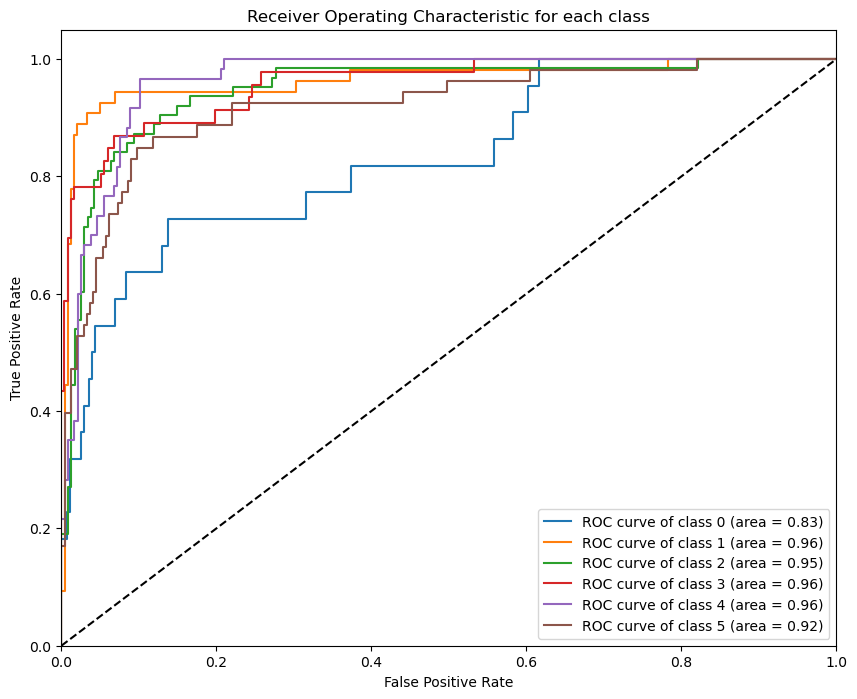

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_0.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        # 获取每个类别的概率分布
        preds_proba = F.softmax(out_class, dim=1)
    return preds_proba[data.val_idx]

# 测试模型并获取预测概率
y_test_proba = test(trained_model, data, config).cpu().numpy()
y_true = data.y[data.val_idx].detach().cpu().numpy()

# 二值化真实标签
num_classes = 6  # 标签从0到6，共有7个类别
y_true_binary = label_binarize(y_true, classes=range(num_classes))

# 计算每个类别的ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()
